<a href="https://colab.research.google.com/github/Prateeklk/Deep-Leaning/blob/main/sign-language-recognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sign-language-mnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3258%2F5337%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T112154Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D565922a9f1c61c192c2560003839fedce2743be7cce34d1ab356462af9b7e97ea14e59960944762a293bed8c31c1d1fb5101857fe671a0e81bfc0f8e06ed03c7ce8a783bbb730f07d71341fe284c96560c8cf349522a65b2444b9549ef18192d0747e9b1404ad47db4d9cbfa14bb8524a019ed1ffb8d31f7848959756e4f6eb2497112b3a7347f5dd7f9a61cbcf10e88b1c2fa84859d82ff52f4c811830eb78d19962c88e229df8ef358a95a4c8c43f41170700f100eef7d3f3e45f3e5ddf43a646ef60cdde86a8c4c9044320d34c5d083617b5faf0089704bd2e8bffc8958c44c47a88c1c17bec41668363fe6b03135ea3882216446fb0f56b524b0a36d429c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 65633206 bytes downloaded
Downloaded and uncompressed: sign-language-mnist
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


# Importing the Packages

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [ ]:
train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test.csv")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
train_label = train_df['label']
train_label.head()

0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

In [ ]:
train_set = train_df.drop(['label'],axis = 1)
train_set.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
X_train = train_set.values.reshape(-1,28,28,1)
print(X_train.shape)

(27455, 28, 28, 1)


In [ ]:
test_label = test_df['label']
X_test = test_df.drop(['label'],axis = 1)
X_test = X_test.values.reshape(-1,28,28,1)
print(X_test.shape)

(7172, 28, 28, 1)


In [ ]:
y_test = test_label
y_test.shape

(7172,)

(-0.5, 27.5, 27.5, -0.5)

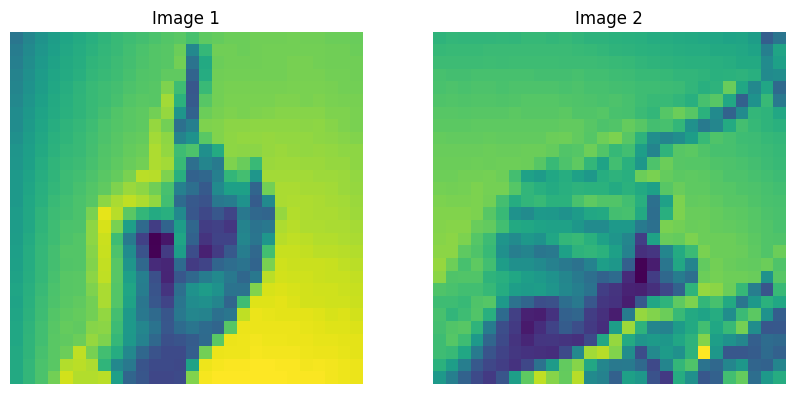

In [ ]:

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].imshow(X_train[0])
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(X_train[1])
axs[1].set_title('Image 2')
axs[1].axis('off')

## Converting the integer label into binary

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(y_test)

In [ ]:
y_train.shape

(27455, 24)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1) (27455, 24) (7172, 24)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/.255,
                                  rotation_range = 8,
                                  height_shift_range = 0.35,
                                  width_shift_range = 0.35,
                                   shear_range = 0.5,
                                   zoom_range = 0.4,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

train_datagen.fit(X_train.reshape(-1,28,28,1))

# Building CNN Model


In [ ]:
input_shape = (28, 28, 1)
model = Sequential()

model.add(Conv2D(128,kernel_size = (5,5),strides = 1, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size = (5,5), strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same'))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPool2D((2,2),1, padding = 'same'))
model.add(Dropout(0.5))

model.add(Flatten())

## Adding the Desnse, Dropout and output layers

In [ ]:
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Trainig the model

In [ ]:
history = model.fit(X_train,y_train, batch_size = 32,
         epochs = 20,
         validation_split = 0.2,
         shuffle = 1
         )


Epoch 1/20
687/687 [==============================] - 9s 13ms/step - loss: 0.5107 - accuracy: 0.8401 - val_loss: 0.1384 - val_accuracy: 0.9547
Epoch 2/20
687/687 [==============================] - 5s 7ms/step - loss: 0.5204 - accuracy: 0.8357 - val_loss: 0.0999 - val_accuracy: 0.9752
Epoch 3/20
687/687 [==============================] - 5s 7ms/step - loss: 0.4927 - accuracy: 0.8471 - val_loss: 0.1397 - val_accuracy: 0.9605
Epoch 4/20
687/687 [==============================] - 5s 7ms/step - loss: 0.4978 - accuracy: 0.8461 - val_loss: 0.0835 - val_accuracy: 0.9776
Epoch 5/20
687/687 [==============================] - 5s 7ms/step - loss: 0.4811 - accuracy: 0.8510 - val_loss: 0.0953 - val_accuracy: 0.9814
Epoch 6/20
687/687 [==============================] - 6s 9ms/step - loss: 0.5122 - accuracy: 0.8483 - val_loss: 0.0894 - val_accuracy: 0.9816
Epoch 7/20
687/687 [==============================] - 6s 8ms/step - loss: 0.4659 - accuracy: 0.8615 - val_loss: 0.0626 - val_accuracy: 0.9878
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

225/225 - 1s - loss: 0.2396 - accuracy: 0.9357 - 847ms/epoch - 4ms/step


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.23963753879070282
Test Accuracy: 0.9357222318649292


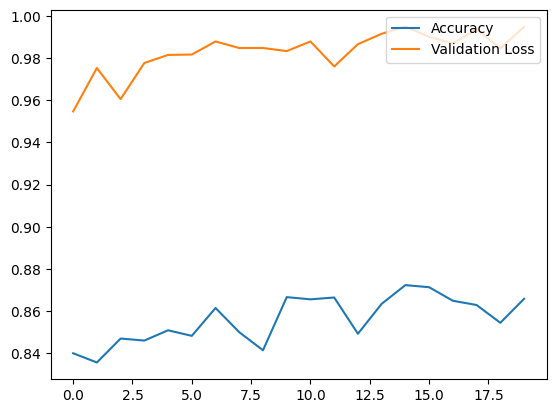

In [ ]:
plt.plot(history.history['accuracy'], label = "Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Loss")
plt.legend(loc='upper right')
plt.show()

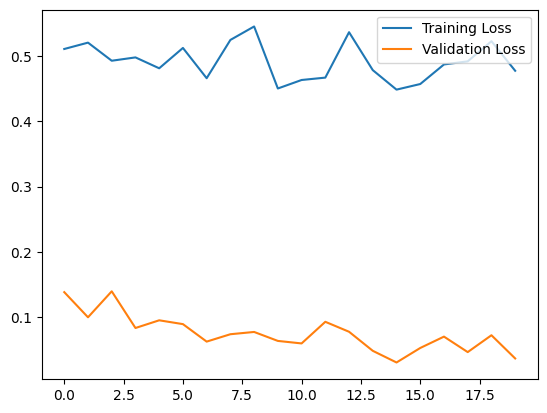

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend(loc='upper right')
plt.show()